# Mudcard
- **If there is no downside to stratified split but there is a potential downside to not doing it should we just always use it?**
    - Yes, you can always use it. 
- **How to sample time-series data which are independent.**
    - I'm not quite sure I understan the question.
    - The level of autocorrelation is an inherent property of time series data, it's not something you or sampling methods have an impact on.
- **I think I'm still trying to understand how the number of K-folds impacts the data. I understand its important, and I wonder if you increase K to 100 how does this change the model.**
    - It depends on the dataset size.
    - If you have a small dataset, a large k means that you'll have a small number of points in each fold.
    - If you have a large dataset, you'll have enough points in each fold but you'll need to train a large number of models on a large dataset which will be computationally expensive.
- **When is it advantageous to use Kfold splitting versus any 60-20-20 split?**
    - When you use the 60-20-20 split, data is not used efficiently because only 60% of the data is used for training.
    - When you set aside 20% for testing, and use 4 folds on the rest of the data, each fold contains 20% of the data, and you use all 4 folds to train models so you use 80% of the data for training.
    - So kfold splitting is better if you have a small dataset and you want to make most of the small dataset.
    - 60-20-20 split is better for larger datasets because you only train one model, it's more computationally efficient. While when you use k fold, you'll train k models which can be costly if your dataset is large.
- **I am still confused on how the data splitting works in code for the 60:20:20 example for Quiz 1. Why was the train set allocated as 0.75**
    - Work out the sizes of each set and you'll see. :)
    - 25% of 80% is 20%
- **What exactly are classes in the context of splitting a data set (say using k-fold)? I understand that you need to represent a minority class when you split and I see in the lecture that the colors represent different classes, but what are these classes exactly?**
    - In classification, your target variable is categories. For example, in fraud detection, transactions can be real and fraudulant. The class label of a real transaction would be 0, and fraudulant transactions would have a class label of 1.
- **In what instances would an imbalanced dataset be more ideal than a balanced dataset?**
    - It is an inherent property of classification datasets how imbalanced they are. It's not a question of what's ideal for you, it's a question of what the level of imbalance is.
- **Are there specific models that are more suited towards imbalanced dataset?**
    - Yes, we will cover techniques best suited to deal with imbalanced classification problems.

# Split non-iid data
By the end of this lecture, you will be able to
- split non-iid data based on group ID
- split non-iid time series data


## Examples of non-iid data
- if there is any sort of time or group structure in your data, it is likely non-iid
    - **group structure:**
        - **samples are not identically distributed, $D$ might be different for each group**
        - a person appears multiple times in the dataset (e.g., hospital/doctor visits)
        - data is collected on multiple instrucments (e.g., equipment failure prediction)
        - geographical data (e.g., data collected about various cities, counties, states, countries)
    - **time series data**
        - **values are not independent**
        - stocks price
        - covid19 cases
        - weather data
        

## Ask yourself these questions!
- What is the intended use of the model? What is it supposed to do/predict?
- What data do you have available at the time of prediction?
- Your split must mimic the intended use of the model only then will you accurately estimate how well the model will perform on previously unseen points (generalization error).
- two examples:
    - if you want to predict the outcome of a new patient's visit to the ER:
        - your test score must be based on patients not included in training and validation
        - your validation score must be based on patients not included in training
        - points of one patient should not be distributed over multiple sets because your generalization error will be off
    - if your dataset contains time series features, make sure you don't use future info to predict the past, that's information leakage

# <font color='lightgray'>Split non-iid data</font>
<font color='lightgray'>By the end of this lecture, you will be able to</font>
- **split non-iid data based on group ID**
- <font color='lightgray'>split non-iid time series data</font>


# An example: seizure project
- you can read the publication [here](https://ieeexplore.ieee.org/document/8857552)
- classification problem:
   - epileptic seizures vs. non-epileptic psychogenic seizures
- data from empatica wrist sensor
   - heart rate, skin temperature, EDA, blood volume pressure, acceleration
- data collection:
   - patients come to the hospital for a few days
   - eeg and video recording to determine seizure type
   - wrist sensor data is collected
- question:
   - Can we use the wrist sensor data to differentiate the two seizure types on new patients?

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/seizure_data.csv')
print(df[df['patient ID'] == 32])

    patient ID            seizure_ID  ACC_mean  BVP_mean  EDA_mean    HR_mean  \
5           32  ID32__day3_arm_1_sz1  1.028539 -0.092102  0.112795  64.748167   
6           32  ID32__day3_arm_1_sz1  1.027986  0.745437  0.130486  63.715667   
7           32  ID32__day2_arm_1_sz0  1.002146  0.150810  0.189272  61.838500   
8           32  ID32__day2_arm_1_sz0  1.005410  0.482859  1.226038  66.240833   
9           32  ID32__day1_arm_1_sz0  0.997017 -0.925122  0.200990  56.103667   
10          32  ID32__day1_arm_1_sz0  1.009207  1.618456  1.679754  64.668167   
27          32  ID32__day1_arm_1_sz0  1.000290  0.046690  0.123165  54.289500   
28          32  ID32__day1_arm_1_sz0  1.010351  0.125039  0.471180  65.060667   
29          32  ID32__day2_arm_1_sz0  1.018163  0.254302  0.206010  61.875833   
30          32  ID32__day2_arm_1_sz0  1.016785  1.242893  0.954649  66.216167   
34          32  ID32__day3_arm_1_sz1  1.008867  0.070180  0.195966  65.995667   
35          32  ID32__day3_a

In [2]:
y = df['label']
patient_ID = df['patient ID']
seizure_ID = df['seizure_ID']
X = df.drop(columns=['patient ID','seizure_ID','label'])
classes, counts = np.unique(y,return_counts=True)
print(classes, counts)
print('balance:',np.max(counts/len(y)))

[0. 1.] [ 86 190]
balance: 0.6884057971014492


In [3]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

def ML_pipeline_kfold_GridSearchCV(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state,stratify=y)
    # splitter for _other
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    scaler = StandardScaler()
    pipe = make_pipeline(scaler,SVC())
    # the parameter(s) we want to tune
    param_grid = {'svc__C': np.logspace(-3,4,num=8),'svc__gamma': np.logspace(-3,4,num=8)}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring = make_scorer(accuracy_score),
                        cv=kf, return_train_score = True)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    return grid, grid.score(X_test, y_test)

In [4]:
test_scores = []
for i in range(5):
    grid, test_score = ML_pipeline_kfold_GridSearchCV(X,y,i*42,5)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:',test_score)
    test_scores.append(test_score)
print('test accuracy:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))

{'svc__C': 1.0, 'svc__gamma': 0.01}
best CV score: 0.9227272727272726
test score: 0.9285714285714286
{'svc__C': 10.0, 'svc__gamma': 0.01}
best CV score: 0.9363636363636363
test score: 0.9285714285714286
{'svc__C': 10.0, 'svc__gamma': 0.01}
best CV score: 0.9045454545454547
test score: 0.9464285714285714
{'svc__C': 10.0, 'svc__gamma': 0.01}
best CV score: 0.9
test score: 0.9285714285714286
{'svc__C': 10.0, 'svc__gamma': 0.01}
best CV score: 0.9363636363636363
test score: 0.9107142857142857
test accuracy: 0.93 +/- 0.01


## This is wrong! A very bad case of data leakage!
- the textbook case of data/information leakage!
- if we just do KFold CV blindly, the points from the same patient end up in different sets
   - when you deploy the model and apply it to data from new patients, that patient's data will be seen for the first time
- the ML pipeline needs to mimic the intended use of the model!
   - we want to split the points based on the patient ID!
   - we want all points from the same patient to be in either train/CV/test

## Group-based split: GroupKFold
<center><img src="figures/groupkfold.png" width="600"></center>


In [5]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
def ML_pipeline_groups_GridSearchCV(X,y,groups,random_state,n_folds):
    # create a test set based on groups
    splitter = GroupShuffleSplit(n_splits=1,test_size=0.2,random_state=random_state)
    for i_other,i_test in splitter.split(X, y, groups):
        X_other, y_other, groups_other = X.iloc[i_other], y.iloc[i_other], groups.iloc[i_other]
        X_test, y_test, groups_test = X.iloc[i_test], y.iloc[i_test], groups.iloc[i_test]
    # check the split
#     print(pd.unique(groups))
#     print(pd.unique(groups_other))
#     print(pd.unique(groups_test))
    # splitter for _other
    kf = GroupKFold(n_splits=n_folds)
    # create the pipeline: preprocessor + supervised ML method
    scaler = StandardScaler()
    pipe = make_pipeline(scaler,SVC())
    # the parameter(s) we want to tune
    param_grid = {'svc__C': np.logspace(-3,4,num=8),'svc__gamma': np.logspace(-3,4,num=8)}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring = make_scorer(accuracy_score),
                        cv=kf, return_train_score = True)
    # do kfold CV on _other
    grid.fit(X_other, y_other, groups=groups_other)
    return grid, grid.score(X_test, y_test)

In [6]:
test_scores = []
for i in range(5):
    grid, test_score = ML_pipeline_groups_GridSearchCV(X,y,patient_ID,i*42,5)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:',test_score)
    test_scores.append(test_score)
print('test accuracy:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))

{'svc__C': 100.0, 'svc__gamma': 0.001}
best CV score: 0.7184206989247313
test score: 0.6666666666666666
{'svc__C': 1.0, 'svc__gamma': 0.1}
best CV score: 0.6416666666666667
test score: 0.059322033898305086
{'svc__C': 10.0, 'svc__gamma': 0.001}
best CV score: 0.5720073891625616
test score: 0.9390243902439024
{'svc__C': 10.0, 'svc__gamma': 0.001}
best CV score: 0.6928409090909091
test score: 0.43243243243243246
{'svc__C': 10000.0, 'svc__gamma': 0.001}
best CV score: 0.5390099715099714
test score: 0.8901098901098901
test accuracy: 0.6 +/- 0.32


## The takeaway
- an incorrect cross validation pipeline gives misleading results
   - usually the model appears to be pretty accurate
   - but the performance is poor when the model is deployed
- this can be avoided by a careful cross validation pipeline
   - think about how your model will be used
   - mimic that future use in CV

# Let's take a look at group splitters using toy datasets

## Group-based split: GroupKFold
<center><img src="figures/groupkfold.png" width="600"></center>


In [7]:
from sklearn.model_selection import GroupKFold
import numpy as np

X = np.ones(shape=(8, 2))
y = np.ones(shape=(8, 1))
groups = np.array([1, 1, 2, 2, 2, 3, 3, 3])

group_kfold = GroupKFold(n_splits=3)

for train_index, test_index in group_kfold.split(X, y, groups):
    print("TRAIN:", train_index, "TEST:", test_index)


TRAIN: [0 1 2 3 4] TEST: [5 6 7]
TRAIN: [0 1 5 6 7] TEST: [2 3 4]
TRAIN: [2 3 4 5 6 7] TEST: [0 1]


In [8]:
help(GroupKFold)

Help on class GroupKFold in module sklearn.model_selection._split:

class GroupKFold(GroupsConsumerMixin, _BaseKFold)
 |  GroupKFold(n_splits=5)
 |
 |  K-fold iterator variant with non-overlapping groups.
 |
 |  Each group will appear exactly once in the test set across all folds (the
 |  number of distinct groups has to be at least equal to the number of folds).
 |
 |  The folds are approximately balanced in the sense that the number of
 |  samples is approximately the same in each test fold.
 |
 |  Read more in the :ref:`User Guide <group_k_fold>`.
 |
 |  For visualisation of cross-validation behaviour and
 |  comparison between common scikit-learn split methods
 |  refer to :ref:`sphx_glr_auto_examples_model_selection_plot_cv_indices.py`
 |
 |  Parameters
 |  ----------
 |  n_splits : int, default=5
 |      Number of folds. Must be at least 2.
 |
 |      .. versionchanged:: 0.22
 |          ``n_splits`` default value changed from 3 to 5.
 |
 |  Notes
 |  -----
 |  Groups appear in a

## Group-based split: GroupShuffleSplit
<center><img src="figures/groupshufflesplit.png" width="600"></center>


In [9]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=10, train_size=.8, random_state=0)

for train_idx, test_idx in gss.split(X, y, groups):
    print("TRAIN:", train_idx, "TEST:", test_idx)


TRAIN: [0 1 2 3 4] TEST: [5 6 7]
TRAIN: [0 1 2 3 4] TEST: [5 6 7]
TRAIN: [2 3 4 5 6 7] TEST: [0 1]
TRAIN: [0 1 2 3 4] TEST: [5 6 7]
TRAIN: [0 1 2 3 4] TEST: [5 6 7]
TRAIN: [0 1 5 6 7] TEST: [2 3 4]
TRAIN: [0 1 5 6 7] TEST: [2 3 4]
TRAIN: [2 3 4 5 6 7] TEST: [0 1]
TRAIN: [2 3 4 5 6 7] TEST: [0 1]
TRAIN: [0 1 5 6 7] TEST: [2 3 4]


## Quiz 1
Go back to the GroupKFold example above. What happens when you change n_splits to 4? Why?

Why could we set the n_splits argument to 5 in GroupShuffleSplit? Check the manual of both methods to find the answer.

Explain your answer in a couple of sentences!

# <font color='lightgray'>Split non-iid data</font>
<font color='lightgray'>By the end of this lecture, you will be able to</font>
- <font color='lightgray'>split non-iid data based on group ID</font>
- **split non-iid time series data**


## Data leakage in time series data is similar!
- do NOT use information in CV which will not be available once your model is deployed
   - don't use future information!
   
<center><img src="figures/timeseriessplit.png" width="600"></center>


## Time series data
- stock price, crypto price, covid-19 positive case counts, etc
- simple data structure:

| time | observation | 
| - | :-: |
| t_0 | y_0 |
| t_1 | y_1 |
| t_2 | y_2 |
| ... | ... |
| t_i | y_i |
| ... | ... |
| t_n-1 | y_n-1 |
| t_n | y_n |

- assumption:
    - the difference between two time points (dt) is constant 
    - e.g., 1 minute, 5 minutes, 1 hour, or 1 day

## Autocorrelation
- the correlation of the time series data with a delayed copy of itself
- delay on the x axis, correlation coefficient on the y axis
- if delay = 0, the correlation coefficient is 1
- if the delay is short, autocorrelation can be high
- autocorrelation tends to subside for longer delays
- let's check an example

(3650, 2)
         Date  Temp
0  1981-01-01  20.7
1  1981-01-02  17.9
2  1981-01-03  18.8
3  1981-01-04  14.6
4  1981-01-05  15.8


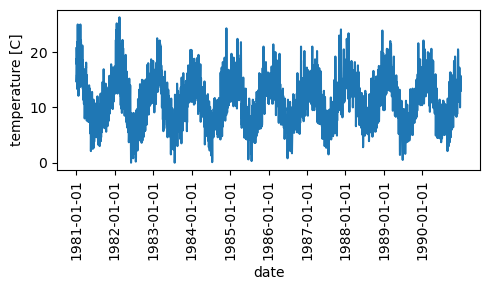

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

df = pd.read_csv('data/daily-min-temperatures.csv')
print(df.shape)
print(df.head())

plt.figure(figsize=(5,3))

plt.plot(df['Temp'])
plt.xticks(np.arange(len(df['Date']))[::365],df['Date'].iloc[::365],rotation=90)
plt.xlabel('date')
plt.ylabel('temperature [C]')
plt.tight_layout()
plt.show()


/Users/azsom/anaconda3/envs/DATA1030/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/azsom/anaconda3/envs/DATA1030/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/azsom/anaconda3/envs/DATA1030/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


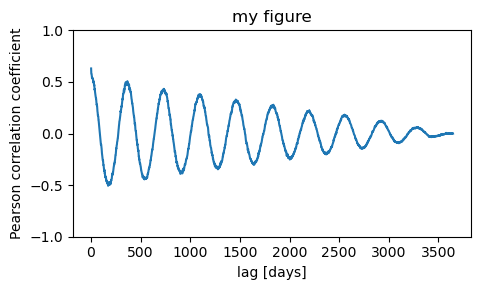

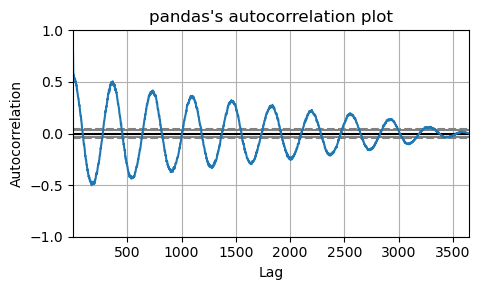

In [14]:
# let's create an autocorrelation plot

lags = np.arange(3650)
corr_coefs = np.zeros(3650)

for i in np.arange(len(lags)):
    x = df['Temp'].iloc[i:-1].reset_index(drop=True) # recent observations
    y = df['Temp'].iloc[:-i-1].reset_index(drop=True) # lag-shifted observations
    # the shapes must be the same
    if x.shape != y.shape:
        raise ValueError('shape mismatch!')
    # Pearson correlation multiplied by the fraction of time series used
    corr_coefs[i] = x.corr(y,method='pearson')*x.shape[0]/df['Temp'].shape[0]

plt.figure(figsize=(5,3))
plt.plot(lags[2:],corr_coefs[2:])
plt.ylim([-1,1])
plt.xlabel('lag [days]')
plt.ylabel('Pearson correlation coefficient')
plt.title('my figure')
plt.tight_layout()
plt.show()

# a one-liner
plt.figure(figsize=(5,3))

pd.plotting.autocorrelation_plot(df['Temp'])
plt.title("pandas's autocorrelation plot")
plt.tight_layout()
plt.show()

# Autoregression: create feature matrix using lag features
- goal:
    - predict what y will be dt in the future
- the target variable and lag features:

| feature_1     | feature_2 	| ... | feature_m-1 | feature m | <font color='red'>target variable</font>|
| - | :-: | :-: | :-: |:-: |:-: |
|     y_0       |    y_1      	| ... | y_m-1   	| y_m	    | <font color='red'>y_m+1</font>|
|     y_1       |    y_2      	| ... | y_m   	    | y_m+1	    | <font color='red'>y_m+2</font>|
|     ...       |    ...      	| ... | ...     	| ...	    | <font color='red'>...</font>  |
|     y_i-m     |    y_i-m+1   	| ... | y_i-2   	| y_i-1	    | <font color='red'>y_i</font>	|
|     ...       |    ...      	| ... | ...     	| ...	    | <font color='red'>...</font>	|
|     y_n-m     |    y_n-m+1   	| ... | y_n-2   	| y_n-1	    | <font color='red'>y_n</font>	|

- the features are shifted with respect to the original observation with a dt lag
- this feature matrix should still be split based on time (e.g., older observations in train, most recent observations in test)

In [12]:
y = df['Temp']
X = pd.concat([df['Temp'].shift(3),df['Temp'].shift(2),df['Temp'].shift(1)],axis=1)
X.columns = ['lag 3 days','lag 2 days','lag 1 day']
print(X.tail(10))
print(y.tail(10))

      lag 3 days  lag 2 days  lag 1 day
3640        14.7        15.4       13.1
3641        15.4        13.1       13.2
3642        13.1        13.2       13.9
3643        13.2        13.9       10.0
3644        13.9        10.0       12.9
3645        10.0        12.9       14.6
3646        12.9        14.6       14.0
3647        14.6        14.0       13.6
3648        14.0        13.6       13.5
3649        13.6        13.5       15.7
3640    13.2
3641    13.9
3642    10.0
3643    12.9
3644    14.6
3645    14.0
3646    13.6
3647    13.5
3648    15.7
3649    13.0
Name: Temp, dtype: float64


## Things to consider
- lag between the target variable and feature m can be more if you want to predict the observation multiple dt's in the future
- you might also have multiple time series to work with (prices of multiple stock, covid cases in multiple countries, etc)
    - all of those need to be shifted by the same lag relative to the target variable
- due to autocorrelation, the features closer in time to the target variable tend to be more predictive
- how many features should you use?
    - treat the number of features as a hyperparameter

## Special scenarios
- what if dt is not consant and/or each time series have its own non-uniform time?
    - for example you try to predict crypto prices based on stock prices
        - stock prices are available once per hour
        - crypto prices are only available when a trade happens (i.e., some tokens are traded rarely)
- interpolate to a uniform time grid
    - try linear and non-linear interpolation techniques to figure out what works best
    - check out [scipy](https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html) for more info
    - cubic spline interpolation usually works well
- you might have a mix of time series and non-time series features
    - cvs customer purchase history
        - you know what a customer bought and when - time series part
        - you have info on the customer (gender, race, address, etc) - non-time series part

## Mud card